In [5]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [6]:
World_happiness= pd.read_csv('cleaned_version')

1. get dummy variables of categorical data using onehotencoder

In [7]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
Arrays= enc.fit_transform(World_happiness[["Country_Name","Regional_Indicator"]]).toarray()

In [8]:
columns=enc.categories_
Column_Arrays= np.concatenate(np.array(columns,dtype=object))
#creating one array out of the column name(country+regional indicator)

In [9]:
Dummie= pd.DataFrame(Arrays, columns=Column_Arrays)

In [10]:
World_happiness1= pd.concat([World_happiness ,Dummie], axis=1)

In [11]:
World_happiness1.drop(["Country_Name", "Regional_Indicator"], axis=1, inplace=True)

3. Seperating the data

In [12]:
X1= World_happiness1.drop("Life_Ladder", axis=1)
y1= World_happiness1['Life_Ladder'].values

3. Doing train test split 

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, random_state=42, shuffle=True)

# Agenda:
1. looking for multicoliniraiety 
2. Linear regression
3. lasso regression
4. ridge regression
5. random forest
6. adaboost regressor
7. SVM regressor 

### 1. Variance Inflation Factor(multicollinearity detection)

In [14]:
X2= World_happiness[["Year","Log_GDP_Per_Capita","Social_Support","Healthy_Life_Expectancy_At_Birth","Freedom_To_Make_Life_Choices","Generosity","Perceptions_Of_Corruption","Negative_Affect","Confidence_In_National_Government","Life_Ladder"]]

In [15]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_data = pd.DataFrame()
vif_data["feature"] = X2.columns
vif_data["VIF"] = [variance_inflation_factor(X2.values, i) for i in range(len(X2.columns))]

In [16]:
vif_data
#From the table down below we can conclude we have severe multicollineairty (5 < VIF) in all but one feature (generosity) 

,feature,VIF
0,Year,283.368456
1,Log_GDP_Per_Capita,284.497183
2,Social_Support,123.121342
3,Healthy_Life_Expectancy_At_Birth,278.598738
4,Freedom_To_Make_Life_Choices,58.136353
5,Generosity,1.211377
6,Perceptions_Of_Corruption,31.734353
7,Negative_Affect,14.972404
8,Confidence_In_National_Government,14.764294
9,Life_Ladder,99.067344


### 2. Linear regression
a: Statmodels

In [17]:
import statsmodels.api as sm
X_sm= X1 = sm.add_constant(X1)
model = sm.OLS(y1,X_sm)

### Please remove double hashtag below and rerun the cell to see full report, it has been commneted out due to big length

In [18]:
##model.fit().summary()

1. Ajusted R - 0.896 (which means the independent variables can explain almost 90 percent of variability in dependent the variable(life ladder))
2. we cannot take our coefficient values seriously due to hufe multicollinearity, hence, even p-values are neglected 
3. the model has a Kurtosis:	4.258, which means the distribustion tails is fatter than a normal ditribustion 	

b: Scikit-learn

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

In [20]:
reg = LinearRegression()
reg.fit(X_train,y_train)
np.mean(cross_val_score(reg, X_train.values, y_train,scoring= 'neg_mean_absolute_error', cv=3)).round(5)
# we are off by 0.29594 life ladder points in our train data

-0.29594

### 2. Lasso regression

In [21]:
from sklearn import linear_model
clf = linear_model.Lasso()
np.mean(cross_val_score(clf, X_train, y_train, scoring= 'neg_mean_absolute_error', cv=3)).round(5)



-0.6606

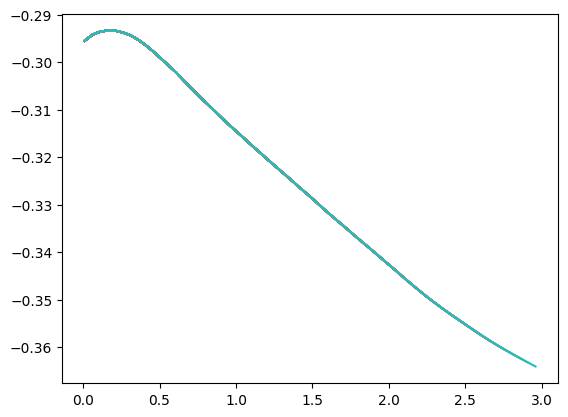

In [22]:
error=[]
alpha=[]
for i in range (1,300,5):
    alpha.append(i/100)
    clf1 = linear_model.Lasso(alpha=i/80000, max_iter=100000)
    error.append(np.mean(cross_val_score(clf1, X_train, y_train, scoring= 'neg_mean_absolute_error', cv=3)))
    plt.plot(alpha,error);
    


In [23]:
columns={"Errors": error, "Alpha": alpha}
Results =pd.DataFrame(columns)
Results[Results.Errors== Results.Errors.max()]
# lasso is optimized when alpha equals 0.16

,Errors,Alpha
3,-0.293339,0.16


### 3. Ridge regression 

In [24]:
from sklearn.linear_model import Ridge
RDG = Ridge()
np.mean(cross_val_score(RDG, X_train, y_train, scoring= 'neg_mean_absolute_error', cv=3)).round(5)

-0.2941

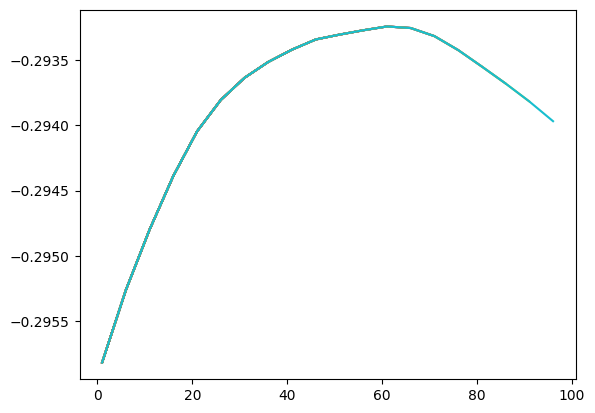

In [25]:
R_error=[]
R_alpha=[]
for i in range (1,100,5):
    R_alpha.append(i)
    RDG1 = RDG = Ridge(alpha=i/100, max_iter=100000)
    R_error.append(np.mean(cross_val_score(RDG1, X_train, y_train, scoring= 'neg_mean_absolute_error', cv=3)))
    plt.plot(R_alpha,R_error);

In [26]:
columns={"Errors": R_error, "Alpha": R_alpha}
Results =pd.DataFrame(columns)
Results[Results.Errors== Results.Errors.max()]

,Errors,Alpha
12,-0.293242,61


### 4. Random Forest 

In [27]:
from sklearn.ensemble import RandomForestRegressor
RF = RandomForestRegressor(random_state=0)
np.mean(cross_val_score(RF, X_train, y_train, scoring= 'neg_mean_absolute_error', cv=3)).round(5)



-0.29076

In [28]:
from sklearn.model_selection import GridSearchCV
parameters = {'criterion':('absolute_error', 'squared_error'), 'n_estimators':range(1,200,10), 'max_features' :('sqrt', 'log2')}
GS= GridSearchCV(estimator=RF ,param_grid=parameters, scoring='neg_mean_absolute_error', cv=3)
GS.fit(X_train,y_train)


GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=0),
             param_grid={'criterion': ('absolute_error', 'squared_error'),
                         'max_features': ('sqrt', 'log2'),
                         'n_estimators': range(1, 200, 10)},
             scoring='neg_mean_absolute_error')

In [29]:
GS.best_score_

-0.2870505722919278

In [30]:
GS.best_estimator_

RandomForestRegressor(criterion='absolute_error', max_features='sqrt',
                      n_estimators=171, random_state=0)

### 5. Adaboost regressor

In [31]:
from sklearn.ensemble import AdaBoostRegressor
Adaboost_Tree = AdaBoostRegressor(random_state=0)


In [32]:
np.mean(cross_val_score(Adaboost_Tree, X_train, y_train, scoring= 'neg_mean_absolute_error', cv=3)).round(5)


-0.3949

In [33]:
Adaboost = AdaBoostRegressor(random_state=0, estimator=RandomForestRegressor(criterion='absolute_error', max_features='sqrt',n_estimators=171, random_state=0))
#Gotten the parameters from GS.best_estimator_

In [34]:
np.mean(cross_val_score(Adaboost, X_train, y_train, scoring= 'neg_mean_absolute_error', cv=3)).round(5)


-0.27575

### Support vector machine

In [35]:
from sklearn.svm import SVR
Regressor= SVR(kernel='linear')



In [36]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X= scaler.fit_transform(X_train)
y= scaler.fit_transform(y_train.reshape(-1,1))
X_t= scaler.fit_transform(X_test)
y_t= scaler.fit_transform(y_test.reshape(-1,1))


In [37]:
np.mean(cross_val_score(Regressor, X, y.ravel(), scoring= 'neg_mean_absolute_error', cv=3)).round(5)


-0.26424

### Test predictions

In [38]:
LR_prediction= reg.fit(X_train,y_train).predict(X_test)
LassoR_rediction= linear_model.Lasso(alpha=0.16).fit(X_train,y_train).predict(X_test)
RidgeR_rediction= Ridge(alpha=61).fit(X_train,y_train).predict(X_test)
adaboostpredict= Adaboost.fit(X_train,y_train).predict(X_test)


In [39]:
RFpredict= GS.best_estimator_.fit(X_train,y_train).predict(X_test)
SVRpredic= Regressor.fit(X,y.ravel()).predict(X_t)

# Prediction against y_test

In [40]:
from sklearn.metrics import mean_absolute_error
print("Linear Regression =" , mean_absolute_error(LR_prediction,y_test).round(4))
print("Lasso Regression =" ,mean_absolute_error(LassoR_rediction,y_test).round(4))
print("Ridge Regression =" ,mean_absolute_error(RidgeR_rediction,y_test).round(4))
print("Random Forest =" ,mean_absolute_error(RFpredict,y_test).round(4))
print("Adaboost with RF as estimator =" ,mean_absolute_error(adaboostpredict,y_test).round(4))
print("Support vector regressor =" ,mean_absolute_error(SVRpredic,y_t).round(4))


Linear Regression = 0.2861
Lasso Regression = 0.5625
Ridge Regression = 0.4047
Random Forest = 0.2675
Adaboost with RF as estimator = 0.2574
Support vector regressor = 0.2819


### Creating Pipeline

In [41]:
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline

In [77]:
col_transformer= make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore'), [0,1]),
    remainder="passthrough"

)


In [78]:
pipe= make_pipeline(col_transformer, Adaboost)

In [79]:
pipe1= make_pipeline(col_transformer, RandomForestRegressor(criterion='absolute_error', max_features='sqrt',n_estimators=171, random_state=0))

In [80]:
X_1= World_happiness.drop('Life_Ladder', axis=1)
y_1= World_happiness['Life_Ladder']

In [81]:
pipe1.fit(X_1.values,y_1)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  [0, 1])])),
                ('randomforestregressor',
                 RandomForestRegressor(criterion='absolute_error',
                                       max_features='sqrt', n_estimators=171,
                                       random_state=0))])

### Creating a pickle of the second best model as the first one is taxing for my personal machine

In [82]:
import joblib
joblib.dump(pipe1, 'pipeline.joblib')

['pipeline.joblib']